In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft as fft
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# ==========================================
# 1. Physics Core: The Forward Operator H(O)
# ==========================================
class FraunhoferForward(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        # Create 2D Bartlett Window to mitigate spectral leakage
        win1d = torch.bartlett_window(size, periodic=False)
        self.register_buffer('window', win1d.view(1, 1, size, 1) * win1d.view(1, 1, 1, size))

    def forward(self, amplitude, phase):
        # Construct Complex Object: O = A * exp(j * phi)
        # Using the complex form: real = A*cos(phi), imag = A*sin(phi)
        real = amplitude * torch.cos(phase)
        imag = amplitude * torch.sin(phase)
        obj_complex = torch.complex(real, imag)

        # Apply Windowing W
        windowed_obj = obj_complex * self.window

        # 2D FFT to Far-field
        f_transform = fft.fft2(windowed_obj)
        f_shifted = fft.fftshift(f_transform, dim=(-2, -1))

        # Intensity measurement: I = |F{O * W}|^2
        intensity = torch.abs(f_shifted)**2
        return intensity

In [9]:
# ==========================================
# 2. Architecture: PhysenNet (Complex-Valued Output)
# ==========================================
class PhysenNet(nn.Module):
    def __init__(self):
        super(PhysenNet, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        # Final layer outputs 2 channels: [Amplitude, Phase]
        self.final = nn.Conv2d(32, 2, 3, padding=1)

    def forward(self, x):
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.dec1(x))
        out = self.final(x)

        # Constrain Amplitude to [0, 1] and Phase to [-pi, pi]
        amplitude = torch.sigmoid(out[:, 0:1, :, :])
        phase = torch.tanh(out[:, 1:2, :, :]) * np.pi
        return amplitude, phase

In [10]:
# ==========================================
# 3. Execution Framework
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 64
forward_physics = FraunhoferForward(IMG_SIZE).to(device)
model = PhysenNet().to(device)

# --- Stage 1: Self-Supervised Pre-training (MNIST Prior) ---
# Goal: Learn the mapping I -> O using standard supervised loss
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=32, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Stage 1: Learning Implicit Image Priors...")
for epoch in range(3): # Extended to 50 for full project
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)

        # Simulate measurement (assuming phase is 0 for MNIST training)
        with torch.no_grad():
            I_meas = forward_physics(imgs, torch.zeros_like(imgs))
            # Log scaling input often helps convergence
            I_input = torch.log1p(I_meas)

        pred_amp, pred_phase = model(I_input)

        # Loss: compare reconstructed amplitude to ground truth image
        loss = nn.MSELoss()(pred_amp, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Pre-training Loss: {loss.item():.6f}")

# --- Stage 2: Physics-Driven Fine-Tuning (The PINN Step) ---
# Using a single specific measurement, NO Labels allowed here.
test_img, _ = next(iter(train_loader))
test_img = test_img[0:1].to(device)

with torch.no_grad():
    # Target measurement we want to solve
    I_target = forward_physics(test_img, torch.zeros_like(test_img))
    I_target_input = torch.log1p(I_target)

print("\nStage 2: Physics-Driven Fine-Tuning (PINN Phase)...")
# Reduce LR for fine-tuning stability
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

for step in range(101):
    pred_amp, pred_phase = model(I_target_input)

    # Calculate Physics-Consistency Loss
    # L_phys = || H(R(I)) - I ||^2
    I_reproduced = forward_physics(pred_amp, pred_phase)
    loss_phys = nn.MSELoss()(I_reproduced, I_target)

    optimizer_ft.zero_grad()
    loss_phys.backward()
    optimizer_ft.step()

    if step % 20 == 0:
        print(f"Fine-tuning Step {step}, Physics Loss: {loss_phys.item():.6e}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.43MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.30MB/s]


Stage 1: Learning Implicit Image Priors...
Epoch 1 Pre-training Loss: 0.060571
Epoch 2 Pre-training Loss: 0.064331
Epoch 3 Pre-training Loss: 0.058101

Stage 2: Physics-Driven Fine-Tuning (PINN Phase)...
Fine-tuning Step 0, Physics Loss: 3.000317e+05
Fine-tuning Step 20, Physics Loss: 2.062102e+05
Fine-tuning Step 40, Physics Loss: 1.923142e+05
Fine-tuning Step 60, Physics Loss: 1.767568e+05
Fine-tuning Step 80, Physics Loss: 1.620930e+05
Fine-tuning Step 100, Physics Loss: 1.448391e+05


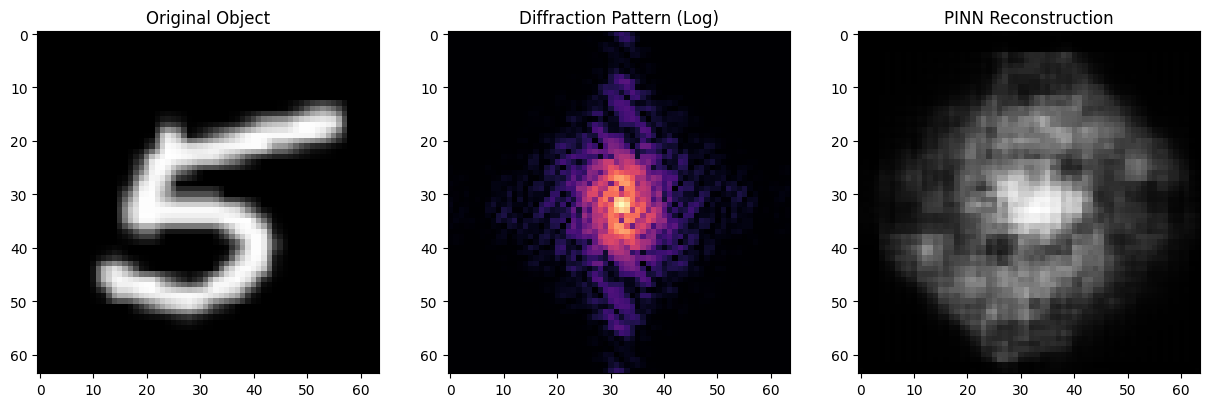

In [11]:
# ==========================================
# 4. Results Visualization
# ==========================================
with torch.no_grad():
    final_amp, _ = model(I_target_input)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(test_img.cpu().squeeze(), cmap='gray'); plt.title("Original Object")
plt.subplot(1, 3, 2); plt.imshow(torch.log1p(I_target).cpu().squeeze(), cmap='magma'); plt.title("Diffraction Pattern (Log)")
plt.subplot(1, 3, 3); plt.imshow(final_amp.cpu().squeeze(), cmap='gray'); plt.title("PINN Reconstruction")
plt.show()